<a href="https://colab.research.google.com/github/SidtheKidx/music-genre-prediction/blob/main/Thrasio_music_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Music genre prediction - classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix
from xgboost import plot_importance
from scipy import interp


In [2]:
music = pd.read_csv('https://raw.githubusercontent.com/SidtheKidx/music-genre-prediction/main/music_genre.csv')

In [3]:
music.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203,Electronic


### EDA and feature engineering

In [4]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [5]:
music.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [6]:
music.shape

(50005, 18)

In [7]:
music['music_genre'].unique()

array(['Electronic', 'Anime', nan, 'Jazz', 'Alternative', 'Country',
       'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [8]:
music['music_genre'].value_counts()

Country        5000
Rap            5000
Alternative    5000
Blues          5000
Classical      5000
Hip-Hop        5000
Electronic     5000
Jazz           5000
Rock           5000
Anime          5000
Name: music_genre, dtype: int64

In [9]:
#Dropping values that are NANs(i.e. 5 values in 'music genre')
music = music[music['music_genre'].notna()]

In [10]:
music['music_genre'].isnull().sum()

0

In [11]:
music['music_genre'].unique()

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [12]:
music.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

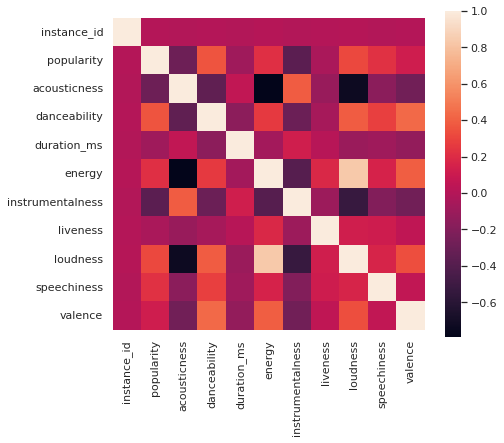

In [13]:
#Finding correlation between features
corrmat = music.corr()
f, ax = plt.subplots(figsize=(7,6))
sns.heatmap(corrmat, square = True)

Right off the bat, we can see:
1. *loudness* and *energy* are **highly correlated**. 
2. Followed by **medium correlation**:
*   *loudness*  and *valence*
*   *instrumentalness* and *acousticness*
*   *loudness* and *danceability* 
*   *energy* and *valence*
*   *danceability* and *valence*
*   *popularity* and *danceability*


In [14]:
music.head(-10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,32849.0,Jeremih,Planez,73.0,0.67400,0.650,240320.0,0.557,0.000000,C#,0.1100,-7.762,Major,0.3120,129.285,4-Apr,0.400,Hip-Hop
49991,40401.0,empty_field,For Real,53.0,0.00392,0.770,211820.0,0.905,0.000003,F,0.1690,-8.235,Minor,0.1440,135.999,4-Apr,0.464,Hip-Hop
49992,67111.0,Ghostemane,Hades,55.0,0.03910,0.829,127128.0,0.590,0.010700,A,0.1140,-7.818,Minor,0.2630,112.97,4-Apr,0.332,Hip-Hop
49993,37756.0,Lecrae,Cry For You,54.0,0.30400,0.642,263467.0,0.353,0.000000,A#,0.0927,-12.384,Minor,0.2150,89.596,4-Apr,0.276,Hip-Hop


In [15]:
music.isnull().sum()

instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

In [16]:
"""
print('Target variables  : ', music.loc[music['music_genre'] == 'Electronic'])
(unique, counts) = np.unique(str(music.loc[music['music_genre'] == 'Electronic']).split(), return_counts=True)
print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)
"""

"\nprint('Target variables  : ', music.loc[music['music_genre'] == 'Electronic'])\n(unique, counts) = np.unique(str(music.loc[music['music_genre'] == 'Electronic']).split(), return_counts=True)\nprint('Unique values of the target variable', unique)\nprint('Counts of the target variable :', counts)\n"

In [17]:
"""
#split dataset in features and target variable
features = ['popularity', 'acousticness', 'instrumentalness', 'speechiness', 'danceability', 
            'liveness', 'valence', 'energy', 'loudness', 'tempo', 'duration_ms']

genre = str(music.loc[music['music_genre'] == 'Electronic'])
"""

"\n#split dataset in features and target variable\nfeatures = ['popularity', 'acousticness', 'instrumentalness', 'speechiness', 'danceability', \n            'liveness', 'valence', 'energy', 'loudness', 'tempo', 'duration_ms']\n\ngenre = str(music.loc[music['music_genre'] == 'Electronic'])\n"

### Encoding categorical data

In [18]:
#OP is using a one hot encoder so the fit function won't work with the array @Ishant Mrinal recommends this Y_train = np.argmax(Y_train, axis=1)

# separate into input and output columns
X = pd.DataFrame(music.iloc[:, :-1])
y = pd.DataFrame(music.iloc[:, -1])


In [19]:
y

,music_genre
0,Electronic
1,Electronic
2,Electronic
3,Electronic
4,Electronic
...,...
50000,Hip-Hop
50001,Hip-Hop
50002,Hip-Hop
50003,Hip-Hop


In [20]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y['genre_Category'] = labelencoder.fit_transform(y)
y

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,music_genre,genre_Category
0,Electronic,5
1,Electronic,5
2,Electronic,5
3,Electronic,5
4,Electronic,5
...,...,...
50000,Hip-Hop,6
50001,Hip-Hop,6
50002,Hip-Hop,6
50003,Hip-Hop,6


In [21]:
y.drop(['music_genre'], axis=1, inplace=True)

In [22]:
# replace ? as np.nan in tempo
X['tempo'].replace(to_replace = '?', value =np.nan, inplace=True)
X['duration_ms'].replace(to_replace = -1, value =np.nan, inplace=True)

In [23]:
X.isnull().sum()

instance_id            0
artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
obtained_date          0
valence                0
dtype: int64

In [24]:
#x = x.dropna(inplace=True)
X.fillna(0,inplace=True)

In [25]:
X.shape

(50000, 17)

In [26]:
y

,genre_Category
0,5
1,5
2,5
3,5
4,5
...,...
50000,6
50001,6
50002,6
50003,6


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123, shuffle=True)

In [28]:
X_train.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)
X_test.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)
X.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
X_train

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
1204,38.0,0.00362,0.378,217627.0,0.6060,0.840000,0.1160,-13.003,0.0261,91.875,0.4360
7270,23.0,0.73200,0.148,297045.0,0.1520,0.738000,0.0897,-22.980,0.0339,139.614,0.1680
40284,29.0,0.98400,0.215,255960.0,0.0688,0.518000,0.1370,-20.354,0.0453,87.014,0.0959
33806,23.0,0.06670,0.403,652817.0,0.8130,0.017100,0.7060,-9.825,0.0835,102.495,0.2800
17574,50.0,0.24100,0.683,250773.0,0.9370,0.000000,0.1520,-4.098,0.1200,135.99200000000002,0.7480
...,...,...,...,...,...,...,...,...,...,...,...
8976,30.0,0.88700,0.558,197240.0,0.2580,0.002490,0.1020,-11.652,0.0279,131.422,0.1300
30037,32.0,0.17700,0.522,168773.0,0.6200,0.000000,0.4880,-7.862,0.0258,88.209,0.6890
16670,52.0,0.09560,0.749,280120.0,0.8440,0.010600,0.3480,-5.900,0.0331,110.001,0.7510
26133,61.0,0.02190,0.772,0.0,0.8790,0.000000,0.1480,-3.423,0.0395,139.972,0.4310


In [30]:
sc_X = StandardScaler() # created an object with the scaling class

X_train = sc_X.fit_transform(X_train)  # Here we fit and transform the X_train matrix
X_test = sc_X.transform(X_test)

In [31]:
X_train

array([[-0.3988246 , -0.88701453, -1.0085189 , ..., -0.66477703,
        -0.34727566, -0.08023696],
       [-1.36521137,  1.24451544, -2.29525124, ..., -0.58752552,
         0.68524701, -1.16322258],
       [-0.97865666,  1.9819678 , -1.92042051, ..., -0.47461947,
        -0.45241177, -1.45457805],
       ...,
       [ 0.50313639, -0.61784442,  1.0670363 , ..., -0.59544875,
         0.04476242,  1.19267525],
       [ 1.08296845, -0.83351997,  1.19570953, ..., -0.5320629 ,
         0.69299001, -0.10044192],
       [ 0.76083952,  0.65045659, -0.58333778, ..., -0.52314926,
         1.43352801,  0.44913288]])

In [32]:
"""scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,1))

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns).reset_index(drop=True, inplace=True)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns).reset_index(drop=True, inplace=True)"""

'scaler = MinMaxScaler()\nscaler.fit(X_train.reshape(-1,1))\n\nX_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns).reset_index(drop=True, inplace=True)\nX_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns).reset_index(drop=True, inplace=True)'

In [33]:
y_train

,genre_Category
1204,5
7270,1
40284,3
33806,2
17574,0
...,...
8976,1
30037,2
16670,0
26133,8


In [34]:
y_test

,genre_Category
5512,1
3428,5
9734,1
18231,0
47649,6
...,...
5380,1
18439,0
5757,1
33871,2


In [35]:
# Train logistic regression model
y_train = np.argmax(y_train, axis=1)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Probabilities of each genre
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: ignored

In [39]:
# Display Results
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

ValueError: ignored

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

ValueError: ignored

In [34]:
# Train random forest model with optimal parameters
rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)
# Probabilities of each genre 
rf_probs = rf.predict(X_test)

In [46]:
print("Accuracy:",metrics.accuracy_score(y_test, rf_probs))
print("Precision:",metrics.precision_score(y_test, rf_probs, average='micro'))
print("Recall:",metrics.recall_score(y_test, rf_probs, average='micro'))

Accuracy: 0.5541
Precision: 0.5541
Recall: 0.5541


In [39]:
# Train model with optimal parameters
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', n_estimators=500, sub_sample = 0.8, num_class = len(genres))
xgb.fit(X_train, y_train)
# Probabilities of each genre
xgb_probs = xgb.predict(X_test)

In [47]:
print("Accuracy:",metrics.accuracy_score(y_test, xgb_probs))
print("Precision:",metrics.precision_score(y_test, xgb_probs, average='weighted'))
print("Recall:",metrics.recall_score(y_test, xgb_probs, average='weighted'))

Accuracy: 0.5816
Precision: 0.5862301462308053
Recall: 0.5816


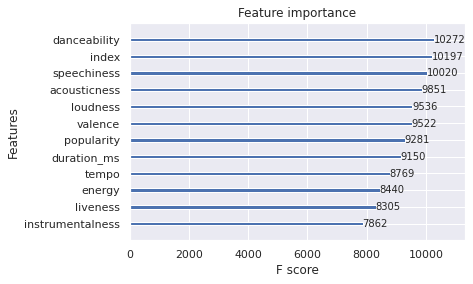

In [48]:
plot_importance(xgb)